# Introduction
A very important aspect of supervised and semi-supervised machine learning is the quality of the labels produced by human labelers. Unfortunately, humans are not perfect and in some cases may even maliciously label things incorrectly. In this assignment, you will evaluate the impact of incorrect labels on a number of different classifiers.

We have provided a number of code snippets you can use during this assignment. Feel free to modify them or replace them.


## Dataset
The dataset you will be using is the [Adult Income dataset](https://archive.ics.uci.edu/ml/datasets/Adult). This dataset was created by Ronny Kohavi and Barry Becker and was used to predict whether a person's income is more/less than 50k USD based on census data.

### Data preprocessing
Start by loading and preprocessing the data. Remove NaN values, convert strings to categorical variables and encode the target variable (the string <=50K, >50K in column index 14).

In [1]:
import json
from collections import defaultdict

import numba
import pandas as pd
import numpy as np
from pandas.core.interchange.dataframe_protocol import Column, DataFrame
from pandas.core.util.hashing import hash_pandas_object
from setuptools.config.pyprojecttoml import load_file
from sklearn.compose import ColumnTransformer
from sklearn.metrics import jaccard_score
from sklearn.preprocessing import OneHotEncoder
#import kshingle as ks
import os
import pandas as pd
from sklearn.metrics import jaccard_score
import numpy as np
from datasketch import MinHash, MinHashLSH
from collections import defaultdict
from typing import Dict, List, Set, Tuple, NamedTuple
import re
import json
import pickle

In [2]:
# This can be used to load the dataset
data = pd.read_csv("adult.csv", header=0, na_values='?')
data = data.dropna()

data = data.convert_dtypes()

numericals = data.select_dtypes(include=[np.number]).columns
categoricals = data.select_dtypes(exclude=[np.number]).columns

data[categoricals] = data[categoricals].astype('category')

encoder = ColumnTransformer(transformers=[('cat', OneHotEncoder(), categoricals)], remainder='passthrough')

#dt = encoder.fit_transform(data)

#for c in data.columns:
#    if data[c].dtype == 'object':
#        data[c] = pd.Categorical(data[c])

#print(dt)
data.head()


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [3]:
print(data.dtypes)

age                  Int64
workclass         category
fnlwgt               Int64
education         category
education-num        Int64
marital-status    category
occupation        category
relationship      category
race              category
sex               category
capital-gain         Int64
capital-loss         Int64
hours-per-week       Int64
native-country    category
salary            category
dtype: object


### Data classification
Choose at least 4 different classifiers and evaluate their performance in predicting the target variable. 

#### Preprocessing
Think about how you are going to encode the categorical variables, normalization, whether you want to use all of the features, feature dimensionality reduction, etc. Justify your choices 

A good method to apply preprocessing steps is using a Pipeline. Read more about this [here](https://machinelearningmastery.com/columntransformer-for-numerical-and-categorical-data/) and [here](https://medium.com/vickdata/a-simple-guide-to-scikit-learn-pipelines-4ac0d974bdcf). 

<!-- #### Data visualization
Calculate the correlation between different features, including the target variable. Visualize the correlations in a heatmap. A good example of how to do this can be found [here](https://towardsdatascience.com/better-heatmaps-and-correlation-matrix-plots-in-python-41445d0f2bec). 

Select a features you think will be an important predictor of the target variable and one which is not important. Explain your answers. -->

#### Evaluation
Use a validation technique from the previous lecture to evaluate the performance of the model. Explain and justify which metrics you used to compare the different models. 

In [4]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Define your preprocessing steps here
steps = []

# Combine steps into a ColumnTransformer
ct = ColumnTransformer(steps)

# show the correlation between different features including target variable
def visualize(data, ct):
    pass

# Apply your model to feature array X and labels y
def apply_model(model, X, y):    
    # Wrap the model and steps into a Pipeline
    pipeline = Pipeline(steps=[('t', ct), ('m', model)])
    
    # Evaluate the model and store results
    return evaluate_model(X, y, pipeline)

# Apply your validation techniques and calculate metrics
def evaluate_model(X, y, pipeline):
    pass

### Label perturbation
To evaluate the impact of faulty labels in a dataset, we will introduce some errors in the labels of our data.


#### Preparation
Start by creating a method which alters a dataset by selecting a percentage of rows randomly and swaps labels from a 0->1 and 1->0. 


In [5]:
"""Given a label vector, create a new copy where a random fraction of the labels have been flipped."""
def pertubate(y: np.ndarray, fraction: float) -> np.ndarray:
    copy = data.copy()
    # Flip fraction*len(data) of the labels in copy
    return copy

#### Analysis
Create a number of new datasets with perturbed labels, for fractions ranging from `0` to `0.5` in increments of `0.1`.

Perform the same experiment you did before, which compared the performances of different models except with the new datasets. Repeat your experiment at least 5x for each model and perturbation level and calculate the mean and variance of the scores. Visualize the change in score for different perturbation levels for all of the models in a single plot. 

State your observations. Is there a change in the performance of the models? Are there some classifiers which are impacted more/less than other classifiers and why is this the case?

In [6]:
# Code

Observations + explanations: max. 400 words

#### Discussion

1)  Discuss how you could reduce the impact of wrongly labeled data or correct wrong labels. <br />
    max. 400 words



    Authors: Youri Arkesteijn, Tim van der Horst and Kevin Chong.


## Machine Learning Workflow

From part 1, you will have gone through the entire machine learning workflow which are they following steps:

1) Data Loading
2) Data Pre-processing
3) Machine Learning Model Training
4) Machine Learning Model Testing

You can see these tasks are very sequential, and need to be done in a serial fashion. 

As a small perturbation in the actions performed in each of the steps may have a detrimental knock-on effect in the task that comes afterwards.

In the final part of Part 1, you will have experienced the effects of performing perturbations to the machine learning model training aspect and the reaction of the machine learning model testing section.

## Part 2 Data Discovery

You will be given a set of datasets and you are tasked to perform data discovery on the data sets.

<b>The datasets are provided in the group lockers on brightspace. Let me know if you are having trouble accessing the datasets</b>

The process is to have the goal of finding datasets that are related to each other, finding relationships between the datasets.

The relationships that we are primarily working with are Join and Union relationships.

So please implement two methods for allowing us to find those pesky Join and Union relationships.

Try to do this with the datasets as is and no processing.



Discovery algorithm:
1. I scan each database with read_csv.
2. I flatten each database, convert it to one string
3. I shingle with k=8
4. I calculate the Jaccard similarity between all pairs of shingles
5. I return the list of relatedness between databases

Comments:
1. File sizes are manageable enough to directly calculate Jaccard similarity without relying on MinHash
2. Tables 10 and 11 are the same
3. For k=8, most similar tables are table_13.csv <> table_7.csv | plain_8=0.1207 | plain_containment_8 = 0.2582 | minhash_8=0.1328
4.
table_6.csv <> table_5.csv | plain_8=0.0958 | plain_containment_8 = 0.2043 | minhash_8=0.0703
table_6.csv <> table_2.csv | plain_8=0.0858 | plain_containment_8 = 0.2544 | minhash_8=0.0859
Significant Jaccard containment scores

In [7]:

@numba.jit(nopython=True)
def kshingle_manual(s, k=6):
   sh = []
   for i in range(len(s) - k + 1):
       sh.append(s[i:i + k])
   return sh


In [8]:

csv_path = "./lake33"


In [128]:
from collections import namedtuple
from collections import defaultdict
import os
import re
import pandas as pd

ColStruct = namedtuple("ColStruct", ["index", "col_name", "value"])

df_dict = {}
df_col_dict = defaultdict(list)
dirty = False

for root, dirs, files in os.walk(csv_path):
    for csv_file in files:
        if os.path.splitext(csv_file)[1] == ".csv":
            file_path = os.path.join(root, csv_file)
            try:
                df = pd.read_csv(file_path, sep=None, engine='python', on_bad_lines='skip', header=0)
                df = df.dropna().astype(object)
                # print(df)
            except Exception:
                continue
            # Serialize whole file (flattened)
            df_str = df.to_numpy().flatten()
            if not dirty:
                df_str = " ".join(str(x) for x in df_str).replace("\n", " ")
                df_str = re.sub(r"\s+", " ", df_str).strip()
            df_dict[csv_file] = df_str

            # Serialize each column for this file
            for col_idx, col in enumerate(df.columns):
                col_arr = df[col].to_numpy().flatten()
                if not dirty:
                    col_str = " ".join(str(x) for x in col_arr).replace("\n", " ")
                    col_str = re.sub(r"\s+", " ", col_str).strip()
                else:
                    col_str = str(col_arr)
                df_col_dict[csv_file].append(ColStruct(index=col_idx, col_name=str(col), value=col_str))
    print(df_col_dict['table3.csv'])

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



22s to read files

In [130]:

print(df_col_dict['table_3.csv'])


[ColStruct(index=0, col_name='ï»¿"REF_DATE"_GEO_DGUID_North', value='2009_Canada_2016A000011124_All 2009_Canada_2016A000011124_All 2009_Canada_2016A000011124_All 2009_Canada_2016A000011124_All 2009_Canada_2016A000011124_All 2009_Canada_2016A000011124_All 2009_Canada_2016A000011124_All 2009_Canada_2016A000011124_All 2009_Canada_2016A000011124_All 2009_Canada_2016A000011124_All 2009_Canada_2016A000011124_All 2009_Canada_2016A000011124_All 2009_Canada_2016A000011124_All 2009_Canada_2016A000011124_All 2009_Canada_2016A000011124_All 2009_Canada_2016A000011124_Oil 2009_Canada_2016A000011124_Electric 2009_Canada_2016A000011124_Electric 2009_Canada_2016A000011124_Electric 2009_Canada_2016A000011124_Electric 2009_Canada_2016A000011124_Electric 2009_Canada_2016A000011124_Food 2009_Canada_2016A000011124_Food 2009_Canada_2016A000011124_Food 2009_Canada_2016A000011124_Food 2009_Canada_2016A000011124_Food 2009_Canada_2016A000011124_Food 2009_Canada_2016A000011124_Food 2009_Canada_2016A000011124_Food

In [118]:
import hashlib
import numpy as np
num_perm = 128

large_prime = np.uint64((1 << 61) - 1) # See datasketch.MinHash. Does not have to be a Mersenne Prime.

max_hash = 2 ** 32 - 1

def get_minwise_perm_params(num_perm=128):
    local_seed = 1
    gen = np.random.Generator(np.random.PCG64(local_seed)) # Apparently better than np.random.RandomState()
    return np.array([
        (
            gen.integers(1, large_prime, dtype=np.uint64),
            gen.integers(0, large_prime, dtype=np.uint64)
        ) for _ in range(num_perm)
    ],
    dtype=np.uint64).T # datasketch.MinHash



def minwise_independent_linear_permuation(hsh, num_perm=128): # (Bohman et. al., 2000)
    a_vals, b_vals = get_minwise_perm_params(num_perm)
    permuted_hashes = np.bitwise_and((a_vals * hsh + b_vals) % large_prime, max_hash) # datasketch.MinHash
    return permuted_hashes

def hash_shingle(shingle):
    shingle_hash = hashlib.blake2b(shingle.encode("utf8"),digest_size=8)
    hashee = int.from_bytes(shingle_hash.digest())
    return np.uint64(hashee)

def MinHash_manual(shingle_set, num_perm=128):
    minhash = np.ones(num_perm) * np.inf
    for shingle in tqdm(shingle_set):
        hash_val = hash_shingle(shingle)
        permuted_hashes = minwise_independent_linear_permuation(hash_val)
        minhash = np.minimum(minhash, permuted_hashes)
    return minhash



In [119]:
from datasketch import MinHash, MinHashLSH

minhash_files = {}
minhash_cols = defaultdict(list)
lookup = {}
mh_file_ind = 0

from CMinHash import CMinHash

from tqdm import tqdm


for fname, text in df_dict.items():
    mh = MinHash()

    for shingle in tqdm(kshingle_manual(text)):
        mh.update(shingle.encode("utf8"))

    #for (col_idx, col_name, col_value) in df_col_dict[fname]:
        #text_ks = kshingle_manual(col_value)
        #for shingle in text_ks:
        #    mh.update(shingle.encode("utf8"))
        #minhash_cols[fname].append((col_idx, col_name, mh))

    minhash_files[fname] = mh


print(f"Mh files {minhash_files}")

  9%|▉         | 1153858/12188826 [00:06<01:00, 182217.62it/s]


KeyboardInterrupt: 

In [155]:
from datasketch import MinHash, MinHashLSH

minhash_files = {}
cminhash_files = {}
cminhash_cols = defaultdict(list)
minhash_cols = defaultdict(list)
lookup = {}
mh_file_ind = 0
import copy
from typing import Callable, Generator, Iterable, List, Optional, Tuple
import warnings

import numpy
import numpy as np
from tqdm import tqdm

from datasketch.hashfunc import sha1_hash32
from CMinHash import CMinHash

from tqdm import tqdm

hashvalue_byte_size = 4

In [121]:
import numba as nb
import numpy as np

@nb.njit(cache=True)
def rot_right_u64(phv: np.ndarray): # Author: Berken Tekin
    """Rotate right the hash values in-place."""
    # Transposing array here instead crashes the code
    # phv shape: (R,_) with dtype=uint64
    R = phv.shape[0]
    #x = phv[0]
    #new_head = x & np.uint64(1)
    #phv[0] = (x >> np.uint64(1)) | (new_head << np.uint64(hashvalue_byte_size * 8 - 1))
    for i in range(1, R): # I just don't rotate vector 0
        x = phv[i-1]
        new_head = x & np.uint64(1)
        phv[i] = (x >> np.uint64(1)) | (new_head << np.uint64(hashvalue_byte_size * 8 - 1))
    return phv


In [122]:
@nb.njit(cache=True)
def rot_right_u64_v2(phv: np.ndarray): # Author: Berken Tekin
    """Rotate right the hash values in-place."""
    # Transposing array here instead crashes the code
    # phv shape: (R,_) with dtype=uint64
    R = phv.shape[0]
    #x = phv[0]
    #new_head = x & np.uint64(1)
    #phv[0] = (x >> np.uint64(1)) | (new_head << np.uint64(hashvalue_byte_size * 8 - 1))
    for i in range(0, R): # I just don't rotate vector 0
        x = np.copy(phv[i])
        new_head = x & np.uint64(1)
        phv[i] = (x >> np.uint64(1)) | (new_head << np.uint64(hashvalue_byte_size * 8 - 1))
    return phv


In [65]:

@nb.njit(cache=True)
def rot_right_u64_v3(d: np.uint64, phv: np.ndarray): # Author: Berken Tekin
    """Rotate right the hash values in-place."""
    # Transposing array here instead crashes the code
    # phv shape: (R,_) with dtype=uint64
    R = phv.shape[0]
    #x = phv[0]
    #new_head = x & np.uint64(1)
    #phv[0] = (x >> np.uint64(1)) | (new_head << np.uint64(hashvalue_byte_size * 8 - 1))
    for i in range(0, R): # I just don't rotate vector 0
        x = np.copy(phv[i])
        new_head = x & (~0 >> (64 - d))
        phv[i] = (x >> np.uint64(d)) | (new_head << np.uint64(hashvalue_byte_size * 8 - d))
    return phv


In [157]:

@nb.njit(cache=True)
def rot_right_u64_v2b(phv: np.ndarray): # Author: Berken Tekin
    """Rotate right the hash values in-place."""
    # Transposing array here instead crashes the code
    # phv shape: (R,_) with dtype=uint64
    R = phv.shape[0]
    x = phv[0]
    new_head = x & np.uint64(1)
    phv[0] = (x >> np.uint64(1)) | (new_head << np.uint64(hashvalue_byte_size * 8 - 1))
    for i in range(1, R): # I just don't rotate vector 0
        x = phv[i-1]
        new_head = x & np.uint64(1)
        phv[i] = (x >> np.uint64(1)) | (new_head << np.uint64(hashvalue_byte_size *  8 - 1))
    return phv



In [232]:

# The size of a hash value in number of bytes

# http://en.wikipedia.org/wiki/Mersenne_prime
_mersenne_prime = 2147483647 # Does not have to be a Mersenne Prime, just a large one
_max_hash = np.uint64((1 << 32) - 1)
_hash_range = 1 << 32
class CMinHashTest(MinHash):
    def __init__(self, num_perm: int = 128, seed: int = 1, hashfunc: Callable = sha1_hash32,
                 hashobj: Optional[object] = None, hashvalues: Optional[Iterable] = None,
                 permutations: Optional[Tuple[Iterable, Iterable]] = None, c_minhash_rotations: Optional[int] = None) -> None:
        super().__init__(num_perm, seed, hashfunc, hashobj, hashvalues, permutations)
        if c_minhash_rotations is not None: # Hard code
            self.c_minhash_rotations = c_minhash_rotations
        self.permutations = self._init_permutations(1)

    def _init_permutations(self, num_perm: int) -> np.ndarray:
        # Create parameters for a random bijective permutation function
        # that maps a 32-bit hash value to another 32-bit hash value.
        # http://en.wikipedia.org/wiki/Universal_hashing
        gen = np.random.RandomState(self.seed)
        return np.array(
            [
                (
                    gen.randint(1, _mersenne_prime, dtype=np.uint64) | 1,
                    gen.randint(0, _mersenne_prime, dtype=np.uint64),
                )
                for _ in range(num_perm)
            ],
            dtype=np.uint64,
        ).T


    def pf(self, hv) -> np.ndarray:
        a, b = self.permutations
        return np.bitwise_and((hv * a + b) % _mersenne_prime, _max_hash)

    def pf2(self, hv, pia) -> np.ndarray:
        a, b = self.permutations
        return np.bitwise_and((hv * a + pia) % _mersenne_prime, _max_hash)


    """ This is more like cminhash-sigma-sigma which I don't like
    def update_batch_cminhash_pi_pi(self, b: Iterable) -> None:
        if self.c_minhash_rotations is None:
            raise ValueError("You need to specify c_minhash_rotations")

        hv = np.array([self.hashfunc(_b) for _b in b], dtype=np.uint64, ndmin=2).T

        phv = hv
        phv = np.repeat(phv, self.c_minhash_rotations, axis=1).T
        phv = rot_right_u64_v2b(phv).T

        self.hashvalues = np.vstack([phv, self.hashvalues]).min(axis=0)
    """


    def update_batch_cminhash_sigma_pi(self, b: Iterable) -> None:
        """Update this MinHash with new values.
        The values will be hashed using the hash function specified by
        the `hashfunc` argument in the constructor.

        """
        if self.c_minhash_rotations is None:
            raise ValueError("You need to specify c_minhash_rotations")

        pi_precomputed = np.array([self.pf(k) for k in range(self.c_minhash_rotations)], dtype=np.uint64).T

        hv = np.array([self.hashfunc(_b) for _b in b], dtype=np.uint64, ndmin=2).T

        phv = self.pf(hv)
        phv = self.pf2(phv, pi_precomputed)



        #phv = np.repeat(phv, self.c_minhash_rotations, axis=1).T
        # https://stackoverflow.com/a/42101326
        #m, n = phv.shape
        #idx = np.mod((n-1)*np.arange(m)[:,None] + np.arange(n) -1, n)
        #full_idx = idx + n*np.arange(m)[:,None]
        #out = np.take(phv, full_idx)
        #out = out.T
        """
        phv[0] = np.roll(phv[0], 1)
        for i in range(len(phv)-1):
            phv[i+1] = np.roll(phv[i], 1)
        phv = phv.T
        """
        # WRONG phv = rot_right_u64_v2b(phv).T

        new_hashvalues = np.vstack([phv, self.hashvalues]).min(axis=0)

        self.hashvalues = new_hashvalues


for fname, text in tqdm(df_dict.items()):
    cmh = CMinHashTest(num_perm=64, c_minhash_rotations=64)
    mh = MinHash(num_perm=64)

    ks = kshingle_manual(text)
    max_buf=128
    for i in range(0, len(ks), max_buf):
        bufsize = min(len(ks)-i, max_buf)
        cmh.update_batch_cminhash_sigma_pi([e.encode("utf8") for e in ks[i:i+bufsize]])
    for (col_idx, col_name, col_value) in df_col_dict[fname]:
        cmh_col = CMinHashTest(num_perm=64, c_minhash_rotations=64)

        ks = kshingle_manual(col_value)
        cmh_col.update_batch_cminhash_sigma_pi([col_value.encode("utf8")])
        cminhash_cols[fname].append(ColStruct(col_idx, col_name ,cmh_col))



    cminhash_files[fname] = cmh


    for i in range(0, len(ks), max_buf):
        bufsize = min(len(ks)-i, max_buf)
        mh.update_batch([e.encode("utf8") for e in ks[i:i+bufsize]])
    for (col_idx, col_name, col_value) in df_col_dict[fname]:
        mh_col = MinHash(num_perm=64)
        ks = kshingle_manual(col_value)
        mh_col.update_batch([col_value.encode("utf8")])
        minhash_cols[fname].append(ColStruct(col_idx, col_name ,mh_col))


    minhash_files[fname] = mh


print(f"Mh files {minhash_files}")

pickle.dump(minhash_files, open("minhash.pkl", "wb"))
pickle.dump(cminhash_files, open("cminhash.pkl", "wb"))


100%|██████████| 16/16 [05:17<00:00, 19.84s/it]

Mh files {'table_0.csv': <datasketch.minhash.MinHash object at 0x000002618DF21080>, 'table_1.csv': <datasketch.minhash.MinHash object at 0x0000026181C13310>, 'table_10.csv': <datasketch.minhash.MinHash object at 0x0000026181C110F0>, 'table_11.csv': <datasketch.minhash.MinHash object at 0x00000261C76B6EB0>, 'table_13.csv': <datasketch.minhash.MinHash object at 0x0000026186883690>, 'table_14.csv': <datasketch.minhash.MinHash object at 0x000002628A83AF90>, 'table_15.csv': <datasketch.minhash.MinHash object at 0x0000026185E34AD0>, 'table_16.csv': <datasketch.minhash.MinHash object at 0x000002618B65AB30>, 'table_17.csv': <datasketch.minhash.MinHash object at 0x000002618B659390>, 'table_2.csv': <datasketch.minhash.MinHash object at 0x0000026186033AF0>, 'table_3.csv': <datasketch.minhash.MinHash object at 0x000002618B62FC40>, 'table_4.csv': <datasketch.minhash.MinHash object at 0x0000026185025A90>, 'table_5.csv': <datasketch.minhash.MinHash object at 0x00000261B1C15320>, 'table_6.csv': <datas

              table_0.csv  table_1.csv  table_10.csv  table_11.csv  \
table_0.csv             1            0             0             0   
table_1.csv             0            1             0             0   
table_10.csv            0            0             1             1   
table_11.csv            0            0             1             1   
table_13.csv            0            0             0             0   
table_14.csv            0            0             0             0   
table_15.csv            0            0             0             0   
table_16.csv            0            0             0             0   
table_17.csv            0            0             0             0   
table_2.csv             0            0             0             0   
table_3.csv             0            0             0             0   
table_4.csv             0            0             0             0   
table_5.csv             0            0             0             0   
table_6.csv         

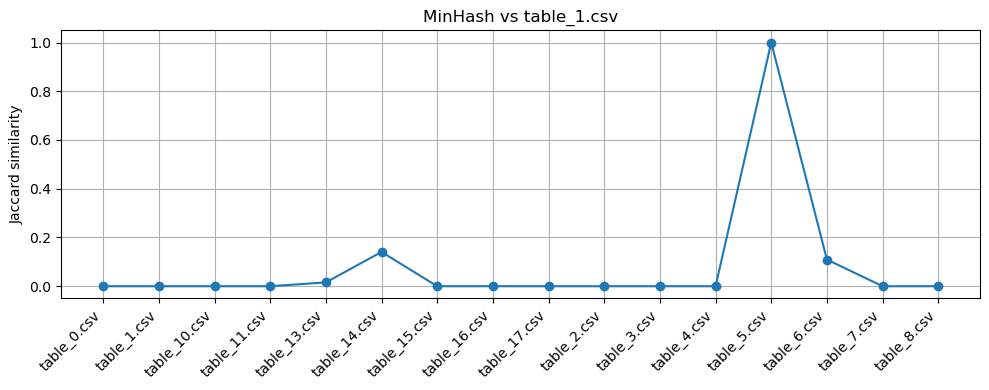

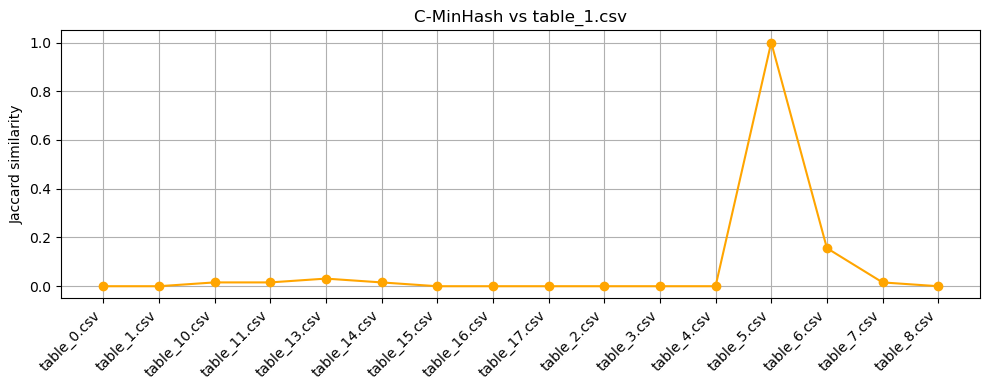

In [236]:
import matplotlib.pyplot as plt

hash_scores = {}
chash_scores = {}
for fname, content in minhash_files.items():
    hash_scores[fname] =  {f: minhash_files[f].jaccard(minhash_files[fname]) for f in minhash_files}
for fname, content in cminhash_files.items():
    chash_scores[fname] = {f: cminhash_files[f].jaccard(cminhash_files[fname]) for f in minhash_files}

df = pd.DataFrame(hash_scores)
cdf = pd.DataFrame(chash_scores)
print(df)


# Compute Jaccard similarities to table_1.csv
hash_scores = {f: minhash_files[f].jaccard(minhash_files['table_5.csv']) for f in minhash_files}
chash_scores = {f: cminhash_files[f].jaccard(cminhash_files['table_5.csv']) for f in cminhash_files}

# Sort keys for consistent plotting
files_sorted = sorted(hash_scores.keys())
hash_vals = [hash_scores[f] for f in files_sorted]
chash_vals = [chash_scores.get(f, None) for f in files_sorted]

# Print values
print(minhash_files['table_2.csv'].jaccard(minhash_files['table_1.csv']))
print(cminhash_files['table_2.csv'].jaccard(cminhash_files['table_1.csv']))
for f in files_sorted:
    print(f"{f} {hash_scores[f]}")
for f in sorted(cminhash_files.keys()):
    print(f"{f} {cminhash_files[f].jaccard(cminhash_files['table_1.csv'])}")

# Plot MinHash similarities
plt.figure(figsize=(10, 4))
plt.plot(files_sorted, hash_vals, marker='o', label='MinHash Jaccard')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Jaccard similarity')
plt.title('MinHash vs table_1.csv')
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot C-MinHash similarities
plt.figure(figsize=(10, 4))
# Filter to only files present in cminhash
files_ch_sorted = sorted(cminhash_files.keys())
chash_vals_plot = [chash_scores[f] for f in files_ch_sorted]
plt.plot(files_ch_sorted, chash_vals_plot, marker='o', color='orange', label='C-MinHash Jaccard')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Jaccard similarity')
plt.title('C-MinHash vs table_1.csv')
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
minhash_files = {}
minhash_cols = defaultdict(list)
lookup = {}
mh_file_ind = 0

for fname, text in df_dict.items():
    text_ks = kshingle_manual(text)
    minhash_files[fname] = MinHash_manual(text, num_perm=128)
    for (col_idx, col_name, col_value) in df_col_dict[fname]:
        text_ks = kshingle_manual(col_value)
        minhash_col = MinHash_manual(text, num_perm=128)
        tup = (col_idx, col_name, minhash_col)
        minhash_cols[fname].append(tup)



OneHash experiment
I will try the OneHash variant

In [ ]:
def OneHash_auto(shingle_set, num_perm=128):
    mh = MinHash(num_perm=1)
    mh.update_batch(shingle_set.encode("utf8") for shingle_set in tqdm(shingle_set))
    return mh.digest()[:num_perm]

def OneHash_manual(shingle_set, num_perm=128):
    for shingle in tqdm(shingle_set):
        hash_val = hash_shingle(shingle)
        permuted_hashes = minwise_independent_linear_permuation(hash_val, num_perm=1)
        minhash = permuted_hashes
    return np.sort(minhash)[:num_perm]
    return minhash


In [ ]:
onehash_files = {}
onehash_cols = defaultdict(list)
lookup = {}
mh_file_ind = 0

for fname, text in df_dict.items():
    text_ks = kshingle_manual(text)
    onehash_files[fname] = (OneHash_auto(text, num_perm=128))
    #for (col_idx, col_name, col_value) in df_col_dict[fname]:
    #    text_ks = kshingle_manual(col_value)
    #    onehash_col = OneHash_manual(text, num_perm=128)
    #    tup = (col_idx, col_name, onehash_col)
    #    onehash_cols[fname].append(tup)



Takes a minute or two

60000 it/s

In [ ]:
def discovery_algorithm_parse_tables(base_dir):
    datasets = {}
    ds = {}
    if not os.path.isdir(base_dir):
        return datasets  # return empty if folder not found
    for fname in os.listdir(base_dir):
        if fname.lower().endswith(".csv"):
            fpath = os.path.join(base_dir, fname)
            try:
                df = pd.read_csv(fpath, sep=None, engine='python', on_bad_lines='skip')
            except Exception:
                continue
            df = df.dropna().astype(object)
            datasets[fname] = df.to_numpy().flatten()
            string = " ".join(str(x) for x in datasets[fname]).replace("\n", " ")
            # merge consecutive whitespaces (book advice)
            string = re.sub(' +', ' ', string)
            ds[fname] = string
    return ds


In [ ]:
def get_shingles(text, k=8):
    return set(kshingle_manual(text, k))

def discovery_algorithm():
    """Function should be able to perform data discovery to find related datasets
    Possible Input: List of datasets
    Output: List of pairs of related datasets
    """

    base_dir = "./lake33"
    ds = discovery_algorithm_parse_tables(base_dir)


    def jaccard_set(set1, set2):
        intersection = len(set1.intersection(set2))
        union = len(set1.union(set2))
        if union == 0:
            return 0.0
        return intersection / union

    def jaccard_containment(set1, set2):
        intersection = len(set1.intersection(set2))
        def jacc_c1(set1, set2):
            if len(set1) == 0:
                return 0.0
            return intersection / len(set1)
        def jacc_c2(set1, set2):
            if len(set2) == 0:
                return 0.0
            return intersection / len(set2)
        return max(jacc_c1(set1, set2), jacc_c2(set1, set2))


    # Cache shingles and MinHash per file per k to avoid recomputing
    #    ks_range = range(8, 9)  # log20 suggests 7.92 (chapter 3 rule of thumb)
    shingles_k = {fname: {} for fname in ds}
    minhash_k = {fname: {} for fname in ds}
    minhashlsh_k = {fname: {} for fname in ds}

    for fname, text in ds.items():
        for k in range(8,9):
            kshingle = set(kshingle_manual(text, 8)) #log20
            shingles_k[fname][k] = kshingle
            mh = MinHash(num_perm=128)
            for sh in kshingle:
                try:
                    mh.update(sh.encode("utf8"))
                except Exception:
                    mh.update(str(sh).encode("utf8"))
            minhash_k[fname][k] = mh

    # MinHash LSH
    for fname, text in ds.items():
        for k in range(8,9):
            minhashlsh_k[fname][k] = MinHashLSH(threshold=0.5, num_perm=128)
            minhashlsh_k[fname][k].insert(fname, minhash_k[fname][k])

    # Print plain Jaccard (set-based) and MinHash estimated Jaccard side by side for each k
    filenames = list(ds.keys())
    for i in range(len(filenames)):
        for j in range(i + 1, len(filenames)):
            f1 = filenames[i]
            f2 = filenames[j]
            parts = [f"{f1} <> {f2}"]
            for k in range(8, 9):
                s1 = shingles_k[f1][k]
                s2 = shingles_k[f2][k]
                plain_j = jaccard_set(s1, s2)
                try:
                    est_j = minhash_k[f1][k].jaccard(minhash_k[f2][k])
                except Exception:
                    est_j = None
                est_lsh_j = minhashlsh_k[f1][k].jaccard(minhashlsh_k[f2][k], query_id=f1)
                parts.append(f"{plain_j:.4f}") # Plain
                parts.append(f"{jaccard_containment(s1, s2):.4f}")
                parts.append(f"{est_j if est_j is None else f'{est_j:.4f}'}")
                parts.append(f"{jaccard_containment(s1, s2):.4f}")
            print(" | ".join(parts))


discovery_algorithm()
print()


Book way

In [ ]:
#import kshingle as ks

from __future__ import annotations
import os
import pandas as pd
from sklearn.metrics import jaccard_score
import numpy as np
from datasketch import MinHash, MinHashLSH
from collections import defaultdict
from typing import Dict, List, Set, Tuple
import re
from collections import namedtuple
import randomhash
import json
import pickle

In [ ]:
# python
from __future__ import annotations
from dataclasses import dataclass
from typing import Any, Iterable, Set, List
import numpy as np
import re

@dataclass(frozen=True)
class DataItem:
    name: str
    whole_file: bool

    # Factory helpers for convenience
    @staticmethod
    def from_array(name: str, arr: Iterable[Any]) -> "ArrayItem":
        return ArrayItem.create(name, arr)

    @staticmethod
    def from_string(name: str, text: str) -> "StringItem":
        return StringItem.create(name, text)

    @staticmethod
    def from_shingles(name: str, shingles: Iterable[str]) -> "ShingleItem":
        return ShingleItem.create(name, shingles)

    # Abstract-like conversions (implemented in subclasses)
    def to_string(self) -> "StringItem":
        raise NotImplementedError

    def to_array(self) -> "ArrayItem":
        raise NotImplementedError

    def to_shingles(self, k: int = 8) -> "ShingleItem":
        raise NotImplementedError


@dataclass(frozen=True)
class ArrayItem(DataItem):
    value: np.ndarray  # 1D flattened array

    @staticmethod
    def create(name: str, arr: Iterable[Any]) -> "ArrayItem":
        if isinstance(arr, np.ndarray):
            val = arr.flatten()
        else:
            val = np.array(list(arr), dtype=object).flatten()
        return ArrayItem(name, val)

    def to_array(self) -> "ArrayItem":
        return self

    def to_shingles(self, k: int = 8) -> "ShingleItem":
        return self.to_string().to_shingles(k=k)


@dataclass(frozen=True)
class StringItem(DataItem):
    value: str

    @staticmethod
    def create(name: str, text: str, normalize_spaces: bool = True) -> "StringItem":
        if normalize_spaces:
            text = re.sub(r"\s+", " ", text.replace("\n", " ")).strip()
        return StringItem(name, text)

    def to_string(self) -> "StringItem":
        return self

    def to_shingles(self, k: int = 8) -> "ShingleItem":
        s = self.value
        if k <= 0:
            raise ValueError("k must be positive")
        shingles: Set[str] = set(s[i : i + k] for i in range(max(0, len(s) - k + 1)))
        return ShingleItem.create(self.name, shingles)


@dataclass(frozen=True)
class ShingleItem(DataItem):
    value: frozenset

    @staticmethod
    def create(name: str, shingles: Iterable[str]) -> "ShingleItem":
        clean = (str(sh) for sh in shingles)
        return ShingleItem(name, frozenset(clean))

    def to_string(self) -> "StringItem":
        # Deterministic order for reproducibility
        text = " ".join(sorted(self.value))
        return StringItem.create(self.name, text)

    def to_array(self) -> "ArrayItem":
        return ArrayItem.create(self.name, list(self.value))

    def to_shingles(self, k: int = 8) -> "ShingleItem":
        return self

Step 0: import DBs

In [ ]:

def _shingle(text: str, k: int = 8) -> Set[str]:
    assert k > 0, "k must be positive"
    if not isinstance(text, str):
        text = str(text)
    n = len(text)
    if n == 0:
        return set()
    return {text[i:i + k] for i in range(max(0, n - k + 1))}

class CsvFile: # Like S_1 in book, or a collection of [S_1, S_2...] in terms of columns.
    minhash: MinHash
    minhash_cols: Dict[str, MinHash]
    filename: str
    all_string: str
    column_strings: Dict[str, str]
    all_shingles: Set[str]
    column_shingles: Dict[str, Set[str]]


    # Shingling helper


    def to_string(self):
        return self.all_string


    @staticmethod
    def apply_minhash(self, curr_set):
        for sh in curr_set:
            try:
                self.minhash.update(sh.encode("utf8"))
            except Exception:
                self.minhash.update(str(sh).encode("utf8"))

    @staticmethod
    def np_to_string(n):
        s = " ".join(str(x) for x in n.flatten())
        s = s.replace("\n", " ")
        s = re.sub(r"\s+", " ", s).strip()
        return s


    def __init__(self, mhf, fp):

        df = pd.read_csv(fp, sep=None, engine='python', on_bad_lines='skip', header=0)
        df = df.dropna().astype(object)
        self.filename = os.path.basename(fp)
        self.all_string = np_to_string(df.to_numpy())
        self.all_shingles = _shingle(self.all_string, k=8)

        self.minhash = mhf
        self.apply_minhash(self.minhash, self.all_shingles)

        # Build serialized strings per column
        self.column_strings = {}
        for col in df.columns:
            col_arr = df[col].to_numpy()
            col_str = self.np_to_string(col_arr)
            self.column_strings[str(col)] = self.np_to_string(col_arr)
            self.column_shingles[str(col)] = _shingle(col_str, k=8)

            self.minhash_cols[str(col)] = MinHash(num_perm=128)
            self.apply_minhash(self.minhash_cols[str(col)], self.column_shingles[str(col)])




class CsvFilesKB:
    files: Dict[str, CsvFile]

    def load_file(self, mhf, fp):
        new_file = CsvFile(mhf, fp)
        fname = new_file.filename
        self.files[fname] = new_file

    def add_csv_files(self, directory):
        for root, dirs, files in os.walk(directory):
            for file in files:
                if file.endswith(".csv"):
                    fpath = os.path.join(root, file)
                    try:
                        self.load_file(fpath)
                    except Exception:
                        continue

    def jaccard_data(self):


    def __init__(self):
        self.files = {}

    def __add__(self, other):
        self.files.update(other.files)
        self.calculateData()

    def __init__(self):
        self.files = {}




class KBRunner:



In [ ]:
def np_to_string(arr):
    arr_t = " ".join(str(x) for x in arr.flatten()).replace("\n", " ")
    return re.sub(' +', ' ', arr_t)

def read_files(dir):
    data_items = List
    for root, dirs, files in os.walk(dir):
        for file in files:

            if file.endswith(".csv"):
                fpath = os.path.join(root, file)
                try:
                    df = pd.read_csv(fpath, sep=None, engine='python', on_bad_lines='skip', header=0)
                except Exception:
                    continue
                df = df.dropna().astype(object)
                datasets[file] = DataItem.from_array("", df.to_numpy().flatten())
                for col in df.columns:
                    # use the first row as label values for this column
                    name = str(df[col].iloc[0])
                    datasets[file] = DataItem.from_array(name, df[col].to_numpy().flatten())

    return datasets


Step 1: Create 8-shingles from data

In [ ]:
def is_whole_file(item: DataItem) -> bool:
    return item.name == ""

In [ ]:

def step_1_kshingles_cols(data_string: DataItem, k=8):

    return data_string.to_shingles(k)

In [ ]:

def step_1_kshingles(data_strs: Dict, k=8):
    shingle_sets = {}
    for fname, string in datasets.items():
        for shingle in kshingle_manual(string, k):
            shingle_sets[fname].add(shingle)
    return shingle_sets



def minhash_wrapper(shingle_set: set):

    minhash = MinHash(num_perm=128)
    for shingle in shingle_set:
        try:
            minhash.update(shingle.encode("utf8"))
        except Exception:
            minhash.update(str(shingle).encode("utf8"))
    return minhash

curr_shinglesets = step_1_kshingles(read_files("./lake33"), 8)
min_hashes = {k: minhash_wrapper(v) for k, v in curr_shinglesets.items()}
print(min_hashes)


Step 2: Sort the document-shingle pairs

In [ ]:
# Python
from datasketch import MinHash, MinHashLSH

def build_minhash_from_shingles(shingle_set, num_perm=128):
    mh = MinHash(num_perm=num_perm)
    for sh in shingle_set:
        mh.update(sh.encode("utf-8"))
    return mh

# Build all shingles once

# Build all MinHashes once with the same num_perm
num_perm = 8
mh_by_file = {fname: build_minhash_from_shingles(s, num_perm) for fname, s in curr_shinglesets.items()}

# Estimate Jaccard between any two files
def est_jaccard(f1, f2):
    return mh_by_file[f1].jaccard(mh_by_file[f2])

# Optional: LSH for fast candidate search (not for exact jaccard)
lsh = MinHashLSH(threshold=0.5, num_perm=num_perm)
for fname, mh in mh_by_file.items():
    lsh.insert(fname, mh)

# Query similar files to 'file_a'
for fname in mh_by_file.keys():
    candidates = [c for c in lsh.query(mh_by_file[fname]) if c != fname]
    print(f"Candidates for {fname}: {candidates}")

# Compute true set Jaccard if needed (slower but exact)
def true_jaccard(f1, f2):
    s1, s2 = curr_shinglesets[f1], curr_shinglesets[f2]
    return len(s1 & s2) / len(s1 | s2) if (s1 or s2) else 0.0

```
Candidates for table_0.csv: []
Candidates for table_1.csv: ['table_2.csv']
Candidates for table_10.csv: ['table_11.csv']
Candidates for table_11.csv: ['table_10.csv']
Candidates for table_13.csv: []
Candidates for table_14.csv: []
Candidates for table_15.csv: []
Candidates for table_16.csv: []
Candidates for table_17.csv: []
Candidates for table_2.csv: ['table_1.csv']
Candidates for table_3.csv: []
Candidates for table_5.csv: []
Candidates for table_6.csv: []
Candidates for table_7.csv: []
```

These values show up even when num_perm=8

You would have noticed that the data has some issues in them.
So perhaps those issues have been troublesome to deal with.

Please try to do some cleaning on the data.

After performing cleaning see if the results of the data discovery has changed?

Please try to explain this in your report, and try to match up the error with the observation.

In [ ]:
## Cleaning data, scrubbing, washing, mopping

def cleaningData(data):
    """Function should be able to clean the data
    Possible Input: List of datasets
    Output: List of cleaned datasets
    """

    pass

## Discussions

1)  Different aspects of the data can effect the data discovery process. Write a short report on your findings. Such as which data quality issues had the largest effect on data discovery. Which data quality problem was repairable and how you choose to do the repair.

<!-- For the set of considerations that you have outlined for the choice of data discovery methods, choose one and identify under this new constraint, how would you identify and resolve this problem? -->

Max 400 words